# Machine Learning in Biology: Predicting Heart Failure based on Patient Medical History and Blood Chemistry

**Written by: Joseph Matthew R. Azanza**

## Main Learning Points (Summary)

1. We can use the Leave One Out Cross Validation method to handle datasets with small samples as the calculated test accuracies are more robust than the train-test split method


2. Application and interpretation of ML in a biological problem is highly context dependent. In this study, while I was able to create an ML model with an 85% accuracy (trained on data from Pakistani patients), applying this model to predict heart failures for non-Pakistani people should be handled with skepticism. There are some context changes on a molecular level that even traditional machine learning models might not account for.


3. The value that the ML model with 85% accuracy gives when we applied in a different context is that it can provide us with a base expectation of what can happen. The ML model is used to augment decision making but not replace the decision makers.

## Introduction

Coming from a molecular biology background, I was really excited to apply the concepts and algorithms learned in our Machine Learning 1 course to biological problems. However, in conceptualizing a problem to solve, I encountered three recurring problems:

1. Publicly available datasets are too complex for traditional ML models, most require Deep Learning models or advanced Image Processing concepts;
2. Public datasets that can be handled by traditional ML models have small sample sizes, typically in the tens to hundreds range, rarely in thousands;
3. Datasets that have large sample sizes and can be handled by traditional ML models are not available publicly and are most likely being processed for publication

To address these problems, I can either wait for next term, where Deep Learning and Image Processing will be discussed, or I can contact some labs and scientists for potential collaboration, but both will take time and I won't be able to present an individual project for ML1.

This led me to the question, "how can we handle publicly available datasets but with small sample sizes?"

### Learning Goals

1. Demonstrate how to handle publicly available datasets with small sample sizes
2. Demonstrate how ML models are interpreted in a biological context

## Data Discussion

The dataset used in this study was obtained from Ahmad, Munir, Bhatti, Aftab, & Raza's paper published in 2017. The data has 299 rows and 13 columns, with each row representing a Pakistani patient and the 12 columns representing the variables (features) that Ahmad, et al. thought were relevant factors that could explain the mortality caused by chronic heart disease.

The features are as follows:

|Feature|Description|Measurement Unit|
|:-:|:-:|:-:|
|Age|Age of the patient|Years|
|Anaemia|Decrease of red blood cells or hemoglobin|Boolean|
|Blood Pressure (BP)|High blood pressure. If a patient has hypertension|Boolean|
|Creatinine phosphokinase (CPK)|Level of the CPK enzyme in the blood| micrograms per Liter (mcg/L)|
|Creatinine|Level of creatinine in the blood|micrograms per deciLiter (mg/dL)|
|Diabetes|If the patient has diabetes|Boolean|
|Ejection fraction|Percentage of blood leaving the heart at each contraction|Percentage|
|Platelets|	Platelets in the blood|kiloplatelets/mL|\
|Sex|Woman or man|Binary|
|Sodium|Level of sodium in the blood|milliequivalents per litre (mEq/L)|
|Smoking|If the patient smokes|Boolean|
|Time|Follow-up period|Days|
|Event|If the patient died during the follow-up period|Boolean|

## Methodology

The high level methodology is as follows. Each step will be further discussed in the next sections.

1. Exploratory Data Analysis
2. Data Clean-up, Feature engineering, Scaling (if necessary)
3. Machine Learning Implementation
    1. Perform usual train-test split
    2. Perform LeaveOneOut cross validation 
4. Compare and discuss results

## Data Loading

### Initalization

In [1]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

# Data Processing Imports
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import export_graphviz
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

# Ignore Warnings
import warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Data Load

In [2]:
df_heart = (pd.read_csv('heart_failure.csv')
            .rename(columns=lambda x: x.strip().replace('.','_').lower())
            .rename(columns={'pletelets':'platelets',
                             'gender':'sex',}).sort_index(axis=1))

print('Shape of dataframe:', df_heart.shape)
display(df_heart.head())

Shape of dataframe: (299, 13)


,age,anaemia,bp,cpk,creatinine,diabetes,ejection_fraction,event,platelets,sex,smoking,sodium,time
0,43.0,1,0,358,1.30,0,50,0,237000.00,0,0,135,97
1,73.0,1,0,231,1.18,1,30,0,160000.00,1,1,142,180
2,70.0,0,1,582,1.83,0,20,1,263358.03,1,1,134,31
3,65.0,1,0,305,1.10,0,25,0,298000.00,1,0,141,87
4,64.0,0,0,1610,1.00,0,60,0,242000.00,1,0,137,113


## Exploratory Data Analysis

### Null values

In [3]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                299 non-null    float64
 1   anaemia            299 non-null    int64  
 2   bp                 299 non-null    int64  
 3   cpk                299 non-null    int64  
 4   creatinine         299 non-null    float64
 5   diabetes           299 non-null    int64  
 6   ejection_fraction  299 non-null    int64  
 7   event              299 non-null    int64  
 8   platelets          299 non-null    float64
 9   sex                299 non-null    int64  
 10  smoking            299 non-null    int64  
 11  sodium             299 non-null    int64  
 12  time               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [4]:
df_heart.isnull().sum()

age                  0
anaemia              0
bp                   0
cpk                  0
creatinine           0
diabetes             0
ejection_fraction    0
event                0
platelets            0
sex                  0
smoking              0
sodium               0
time                 0
dtype: int64

There appears to be no null / missing values in our dataset. Everything also appears to have been converted to numerical values already, including the categorical ones like `sex`, `anemia` etc. Let's now look at the distribution and the range of values

### Distribution Plots

In [5]:
df_heart.describe()

,age,anaemia,bp,cpk,creatinine,diabetes,ejection_fraction,event,platelets,sex,smoking,sodium,time
count,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.000000
mean,60.833893,0.431438,0.351171,581.839465,1.39388,0.418060,38.083612,0.32107,263358.029264,0.648829,0.32107,136.625418,130.260870
std,11.894809,0.496107,0.478136,970.287881,1.03451,0.494067,11.834841,0.46767,97804.236869,0.478136,0.46767,4.412477,77.614208
min,40.000000,0.000000,0.000000,23.000000,0.50000,0.000000,14.000000,0.00000,25100.000000,0.000000,0.00000,113.000000,4.000000
25%,51.000000,0.000000,0.000000,116.500000,0.90000,0.000000,30.000000,0.00000,212500.000000,0.000000,0.00000,134.000000,73.000000
50%,60.000000,0.000000,0.000000,250.000000,1.10000,0.000000,38.000000,0.00000,262000.000000,1.000000,0.00000,137.000000,115.000000
75%,70.000000,1.000000,1.000000,582.000000,1.40000,1.000000,45.000000,1.00000,303500.000000,1.000000,1.00000,140.000000,203.000000
max,95.000000,1.000000,1.000000,7861.000000,9.40000,1.000000,80.000000,1.00000,850000.000000,1.000000,1.00000,148.000000,285.000000


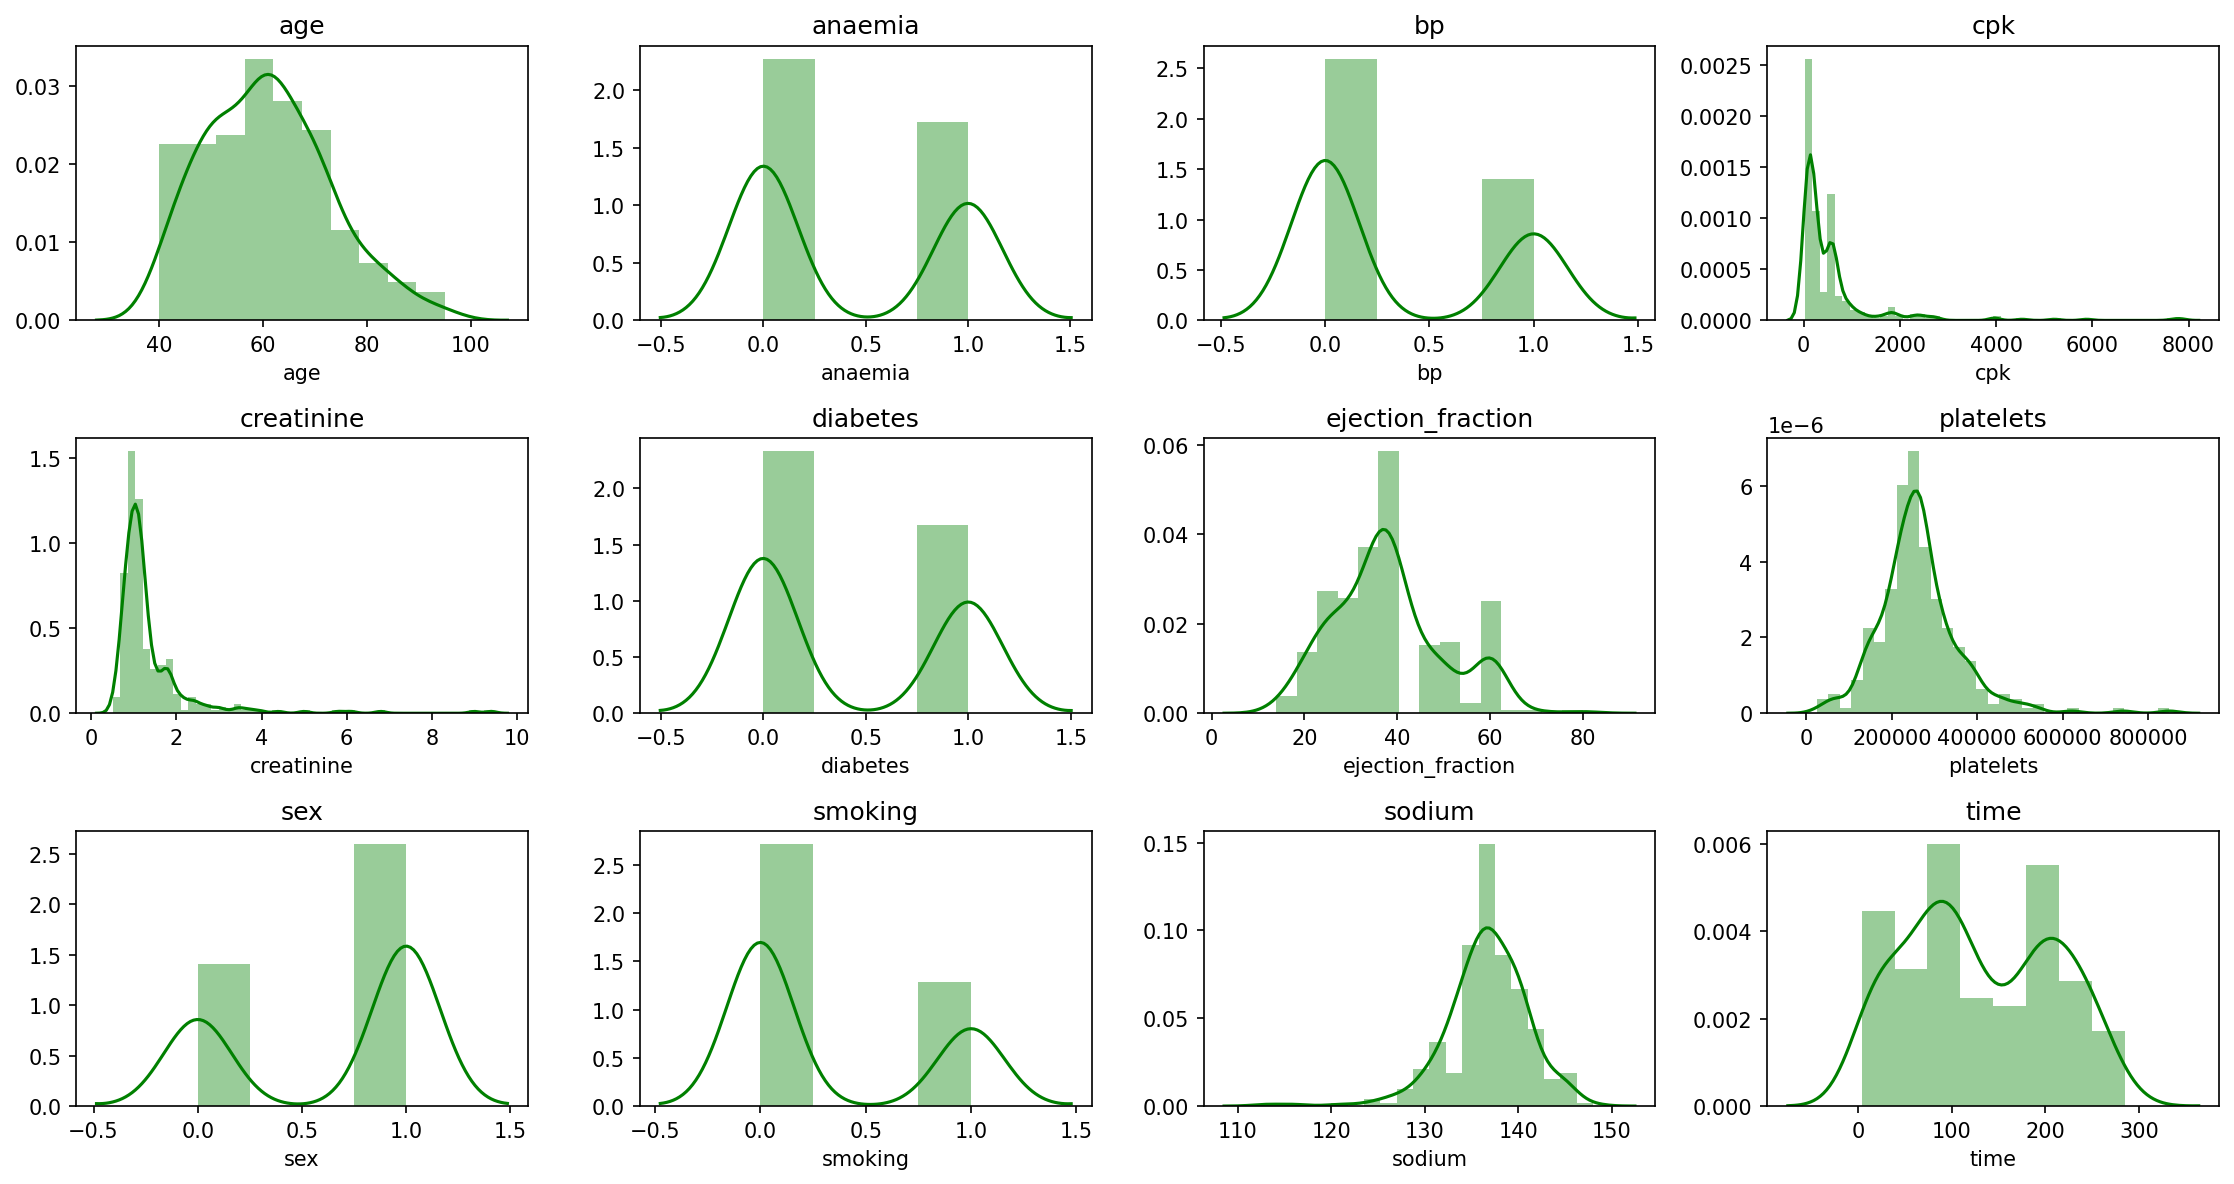

In [6]:
df_eda = df_heart.drop(columns='event',axis=1)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=[15,8], dpi=150)

for ax, (name, data) in zip(axes.flat, df_eda.iteritems()):
    sns.distplot(data, ax=ax, color='Green')
    ax.set_title(name)

plt.tight_layout()
plt.show()

A few key observations from the plots above:
    
1. Age ranges from 40 to 95 with most of the patients at around 60 years old
2. There more non-anemic patients
3. There more non high-blood patients 
4. CPK and creatinine measurements have an outlier at around 8000k and 10, respectively
5. There more non-diabetic patients
6. Platelet measurements also have an outlier at around 8M
7. There are more males than females
8. There are more non-smoking patients
9. Sodium levels range from 110 to 150, with skewnewss to the right
10. Time range is very large, ranging from 0 days to ~280 days

The scales of the features are largely varied. For a more robust processing, these features will be scaled later.

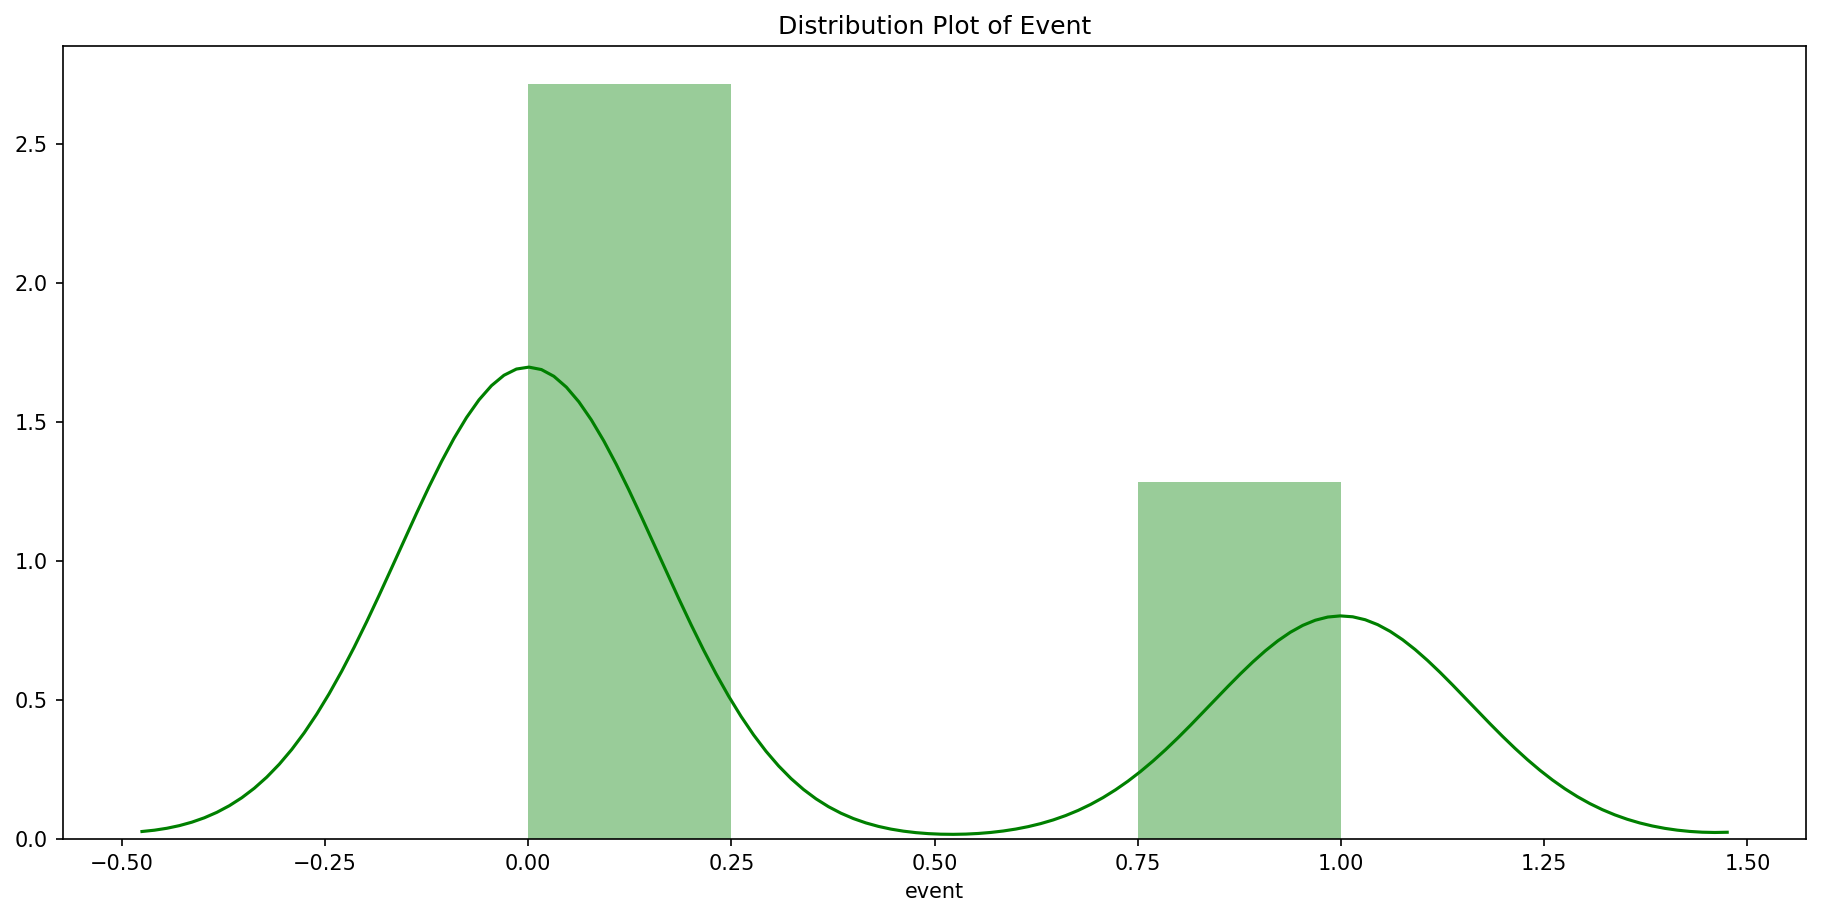

0    203
1     96
Name: event, dtype: int64

In [7]:
plt.figure(figsize=(15,7), dpi=150)
sns.distplot(df_heart['event'], color='Green')
plt.title('Distribution Plot of Event')
plt.show()

display(df_heart['event'].value_counts())

There are also more patients who did not die (`event=0`) than those who died (`event=1`)

### Calculation of 1.25 PCC

In [8]:
pcc = ((df_heart['event'].value_counts().loc[0] 
        / df_heart['event'].value_counts().sum())**2 
       + (df_heart['event'].value_counts().loc[1] 
          / df_heart['event'].value_counts().sum())**2)
pcc
print('1.25 PCC = ', 100*1.25*pcc,'%')

1.25 PCC =  70.50396528003041 %


The accuracy to beat (1.25 PCC) in predicting whether patients will die or not due to heart failure is 70.50%

### Correlation Heatmap

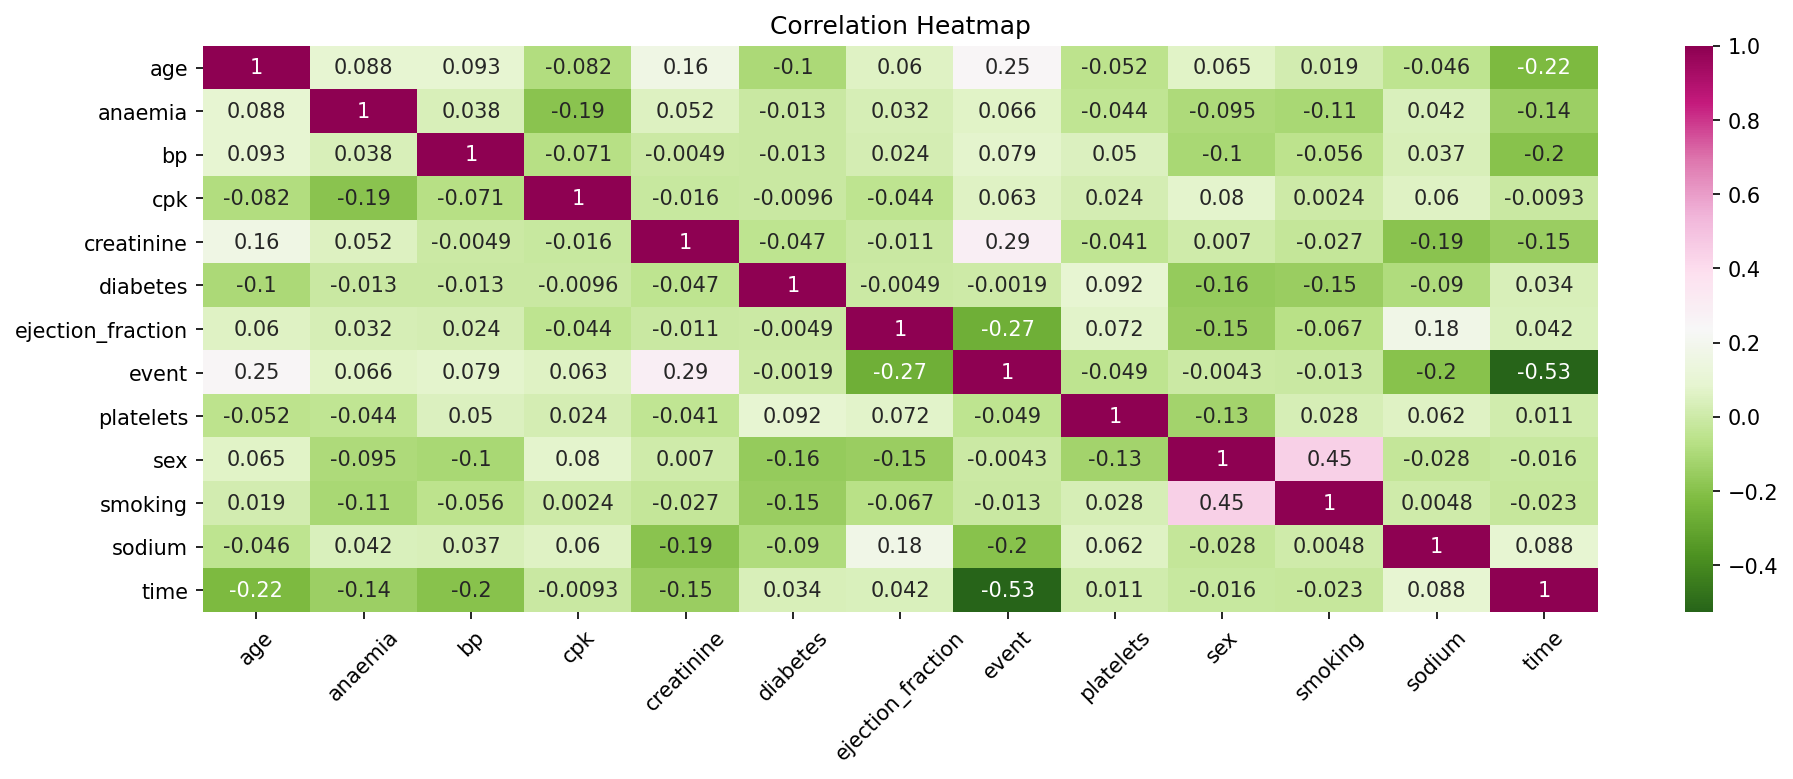

In [9]:
plt.figure(figsize=[15,5], dpi=150)
sns.heatmap(df_heart.corr(), annot=True, cmap='PiYG_r')
plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.show()

From the correlation heatmap above we can see that:
    
1. `age` is correlated with `event`, with $\rho=0.25$
2. `age` is correlated with `creatinine`, with $\rho=0.16$
3. `creatinine` is correlated with `event`, with $\rho=0.29$
4. `ejection_fraction` is correlated with `sodium`, with $\rho=0.18$
5. `sex` is correlated with `smoking`, with $\rho=0.45$

The observed correlation values suggest that dying can be associated with higher age and whether creatinine levels are higher. There are also more male smokers than female smokers and more blood leaves the heart when blood sodium levels are higher (`ejection_fraction` and `sodium`)

## Data Processing

Seeing as there's no need to do imputation or drop null-values, only scaling is needed to be done before performing the classification algorithms.

### Scaling of Features

In [10]:
scaler = MinMaxScaler()

df_data = pd.DataFrame(scaler.fit_transform(df_eda), columns=df_eda.columns)

df_data

,age,anaemia,bp,cpk,creatinine,diabetes,ejection_fraction,platelets,sex,smoking,sodium,time
0,0.054545,1.0,0.0,0.042740,0.089888,0.0,0.545455,0.256880,0.0,0.0,0.628571,0.330961
1,0.600000,1.0,0.0,0.026537,0.076404,1.0,0.242424,0.163535,1.0,1.0,0.828571,0.626335
2,0.545455,0.0,1.0,0.071319,0.149438,0.0,0.090909,0.288833,1.0,1.0,0.600000,0.096085
3,0.454545,1.0,0.0,0.035979,0.067416,0.0,0.166667,0.330828,1.0,0.0,0.800000,0.295374
4,0.436364,0.0,0.0,0.202475,0.056180,0.0,0.696970,0.262941,1.0,0.0,0.685714,0.387900
...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.090909,0.0,0.0,0.071319,0.056180,1.0,0.621212,0.627834,0.0,0.0,0.542857,0.875445
295,0.200000,0.0,0.0,0.071319,0.044944,1.0,0.393939,0.237483,0.0,0.0,0.600000,0.854093
296,0.090909,0.0,0.0,0.071319,0.033708,0.0,0.000000,0.170809,1.0,0.0,0.400000,0.035587
297,0.363636,0.0,0.0,0.111508,0.056180,1.0,0.469697,0.329616,1.0,0.0,0.571429,0.270463


MinMaxScaling was selected over StandardScaling since I wanted to keep the values of the features between [0,1] and not have negative values.

In [11]:
df_target = df_heart['event']
df_target

0      0
1      0
2      1
3      0
4      0
      ..
294    0
295    0
296    1
297    0
298    0
Name: event, Length: 299, dtype: int64

## Machine Learning Implementation

The models used in this section are as follows:
1. kNN Classifier
2. Logistic Regression (L2 Regularization)
3. Logistic Regression (L1 Regularization)
4. Linear SVM (L2 Regularization)
5. Linear SVM (L1 Regularization)
6. Single Decision Tree Classifier
7. Random Forest Clasifier
8. Gradient Boosting Method Classifier

### Run using traditional train-test split

In [12]:
(X_train, X_test,
 y_train, y_test )= train_test_split(df_data, df_target, test_size=0.25,
                                     stratify=df_target, random_state=25)

In [13]:
kNN = KNeighborsClassifier(n_jobs=-1) 
kNN.fit(X_train,y_train)

LR_l2 = LogisticRegression(n_jobs=-1)
LR_l2.fit(X_train, y_train)

LR_l1 = LogisticRegression(penalty='l1', solver='liblinear')
LR_l1.fit(X_train, y_train)

LSVM_l2 = LinearSVC()
LSVM_l2.fit(X_train, y_train)

LSVM_l1 = LinearSVC(penalty='l1', dual=False)
LSVM_l1.fit(X_train, y_train)

DT = DecisionTreeClassifier() 
DT.fit(X_train,y_train)

RF = RandomForestClassifier(n_jobs=-1) 
RF.fit(X_train,y_train)

GBM = GradientBoostingClassifier() 
GBM.fit(X_train,y_train)

cols = ['Machine Learning Model','Train Accuracy', 'Test Accuracy']

df2 = pd.DataFrame(columns=cols)

df2.loc[0] = ['kNN', kNN.score(X_train, y_train), kNN.score(X_test, y_test)]
df2.loc[1] = ['Logistic Regression (L2 Reg)',
              LR_l2.score(X_train, y_train), LR_l2.score(X_test, y_test)]
df2.loc[2] = ['Logistic Regression (L1 Reg)',
              LR_l1.score(X_train, y_train), LR_l1.score(X_test, y_test)]
df2.loc[3] = ['Linear SVM (L2 Reg)', 
              LSVM_l2.score(X_train, y_train), LSVM_l2.score(X_test, y_test)]
df2.loc[4] = ['Linear SVM (L1 Reg)', 
              LSVM_l1.score(X_train, y_train), LSVM_l1.score(X_test, y_test)]
df2.loc[5] = ['Decision Tree', DT.score(X_train, y_train), 
              DT.score(X_test, y_test)]
df2.loc[6] = ['Random Forest', RF.score(X_train, y_train), 
              RF.score(X_test, y_test)]
df2.loc[7] = ['Gradient Boosting Method', 
              GBM.score(X_train, y_train), GBM.score(X_test, y_test)]


df2

,Machine Learning Model,Train Accuracy,Test Accuracy
0,kNN,0.767857,0.693333
1,Logistic Regression (L2 Reg),0.825893,0.880000
2,Logistic Regression (L1 Reg),0.857143,0.853333
3,Linear SVM (L2 Reg),0.852679,0.840000
4,Linear SVM (L1 Reg),0.861607,0.840000
5,Decision Tree,1.000000,0.786667
6,Random Forest,1.000000,0.906667
7,Gradient Boosting Method,1.000000,0.866667


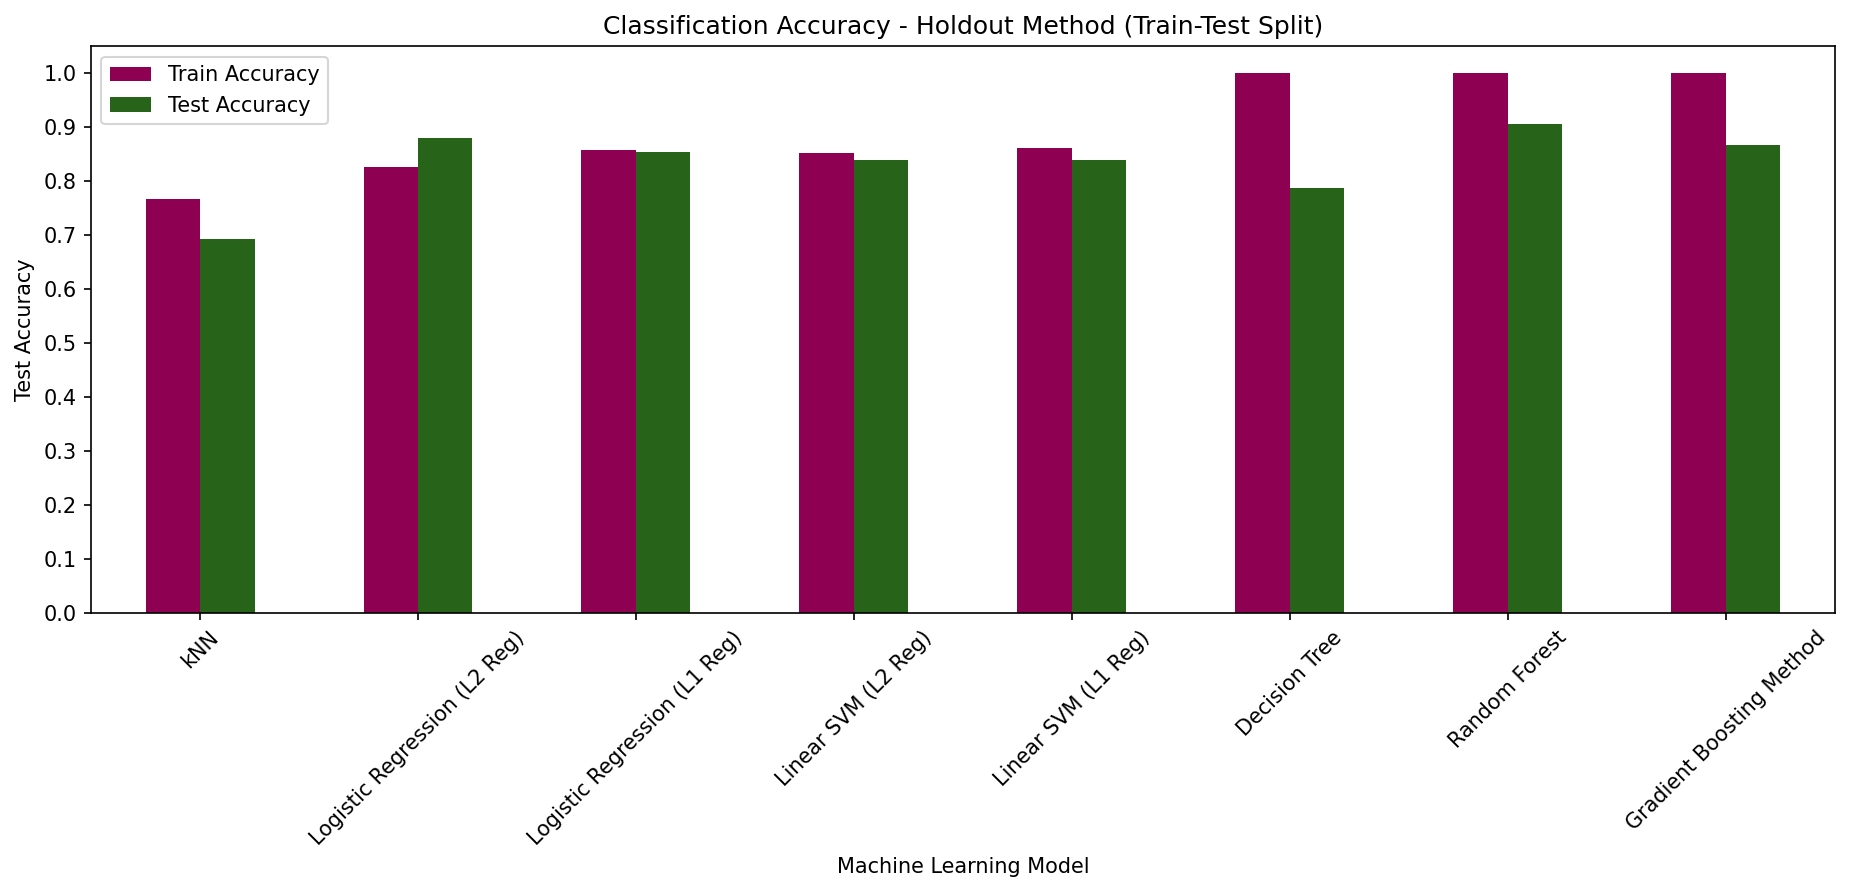

In [14]:
plt.rcParams["figure.dpi"] = 150
df2.set_index('Machine Learning Model').plot.bar(figsize=(15,5), 
                                                 colormap='PiYG')
plt.title('Classification Accuracy - Holdout Method (Train-Test Split)')
plt.xlabel('Machine Learning Model')
plt.ylabel('Test Accuracy')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0,1.05)
plt.xticks(rotation=45)
plt.legend(loc='upper left')
# plt.savefig('holdout_results.png', dpi=150, bbox_inches = 'tight')
plt.show()

### Run using Leave One Out Cross Validation (LOOCV) Method

In [15]:
loo = LeaveOneOut()
loo.get_n_splits(df_data)

kNN_train = []
LR_l2_train = []
LR_l1_train = []
LSVM_l2_train = []
LSVM_l1_train = []
DT_train = []
RF_train = []
GBM_train = []

y_pred_kNN_all = []
y_pred_LR_l2_all = []
y_pred_LR_l1_all = []
y_pred_LSVM_l2_all = []
y_pred_LSVM_l1_all = []
y_pred_DT_all = []
y_pred_RF_all = []
y_pred_GBM_all = []

y_true_all = []

DT_features = []
RF_features = []
GBM_features = []

for train_index, test_index in tqdm(loo.split(df_data)):
    X_train, X_test = (df_data.iloc[train_index].to_numpy(), 
                       df_data.iloc[test_index].to_numpy())
    y_train, y_test = (df_target.iloc[train_index].to_numpy(), 
                       df_target.iloc[test_index].to_numpy())

    kNN = KNeighborsClassifier(n_jobs=-1) 
    kNN.fit(X_train,y_train)
    kNN_train.append(kNN.score(X_train, y_train))
        
    LR_l2 = LogisticRegression(n_jobs=-1)
    LR_l2.fit(X_train, y_train)
    LR_l2_train.append(LR_l2.score(X_train, y_train))
    
    LR_l1 = LogisticRegression(penalty='l1', solver='liblinear')
    LR_l1.fit(X_train, y_train)
    LR_l1_train.append(LR_l1.score(X_train, y_train))
    
    LSVM_l2 = LinearSVC()
    LSVM_l2.fit(X_train, y_train)
    LSVM_l2_train.append(LSVM_l2.score(X_train, y_train))
    
    LSVM_l1 = LinearSVC(penalty='l1', dual=False)
    LSVM_l1.fit(X_train, y_train)
    LSVM_l1_train.append(LSVM_l1.score(X_train, y_train))

    DT = DecisionTreeClassifier() 
    DT.fit(X_train,y_train)
    DT_train.append(DT.score(X_train, y_train))
    DT_features.append(DT.feature_importances_)
    
    RF = RandomForestClassifier(n_jobs=-1) 
    RF.fit(X_train,y_train)
    RF_train.append(RF.score(X_train, y_train))
    RF_features.append(RF.feature_importances_)
    
    GBM = GradientBoostingClassifier() 
    GBM.fit(X_train,y_train)
    GBM_train.append(GBM.score(X_train, y_train))
    GBM_features.append(GBM.feature_importances_)

    y_pred_kNN_all.append(kNN.predict(X_test))
    y_pred_LR_l2_all.append(LR_l2.predict(X_test))
    y_pred_LR_l1_all.append(LR_l1.predict(X_test))
    y_pred_LSVM_l2_all.append(LSVM_l2.predict(X_test))
    y_pred_LSVM_l1_all.append(LSVM_l1.predict(X_test))
    y_pred_DT_all.append(DT.predict(X_test))
    y_pred_RF_all.append(RF.predict(X_test))
    y_pred_GBM_all.append(GBM.predict(X_test))
    
    y_true_all.append(y_test)
    
cols = ['Machine Learning Model','Train Accuracy', 'Test Accuracy']

df3 = pd.DataFrame(columns=cols)

df3.loc[0] = ['kNN', np.mean(kNN_train), 
              accuracy_score(y_true_all, y_pred_kNN_all)]
df3.loc[1] = ['Logistic Regression (L2 Reg)', np.mean(LR_l2_train), 
              accuracy_score(y_true_all, y_pred_LR_l2_all)]
df3.loc[2] = ['Logistic Regression (L1 Reg)', np.mean(LR_l1_train),
              accuracy_score(y_true_all, y_pred_LR_l1_all)]
df3.loc[3] = ['Linear SVM (L2 Reg)', np.mean(LSVM_l2_train), 
              accuracy_score(y_true_all, y_pred_LSVM_l2_all)]
df3.loc[4] = ['Linear SVM (L1 Reg)', np.mean(LSVM_l1_train), 
              accuracy_score(y_true_all, y_pred_LSVM_l1_all)]
df3.loc[5] = ['Decision Tree', np.mean(DT_train), 
              accuracy_score(y_true_all, y_pred_DT_all)]
df3.loc[6] = ['Random Forest', np.mean(RF_train), 
              accuracy_score(y_true_all, y_pred_RF_all)]
df3.loc[7] = ['Gradient Boosting Method', np.mean(GBM_train),
              accuracy_score(y_true_all,y_pred_GBM_all)]

df3

,Machine Learning Model,Train Accuracy,Test Accuracy
0,kNN,0.789343,0.715719
1,Logistic Regression (L2 Reg),0.844942,0.829431
2,Logistic Regression (L1 Reg),0.841362,0.826087
3,Linear SVM (L2 Reg),0.854156,0.836120
4,Linear SVM (L1 Reg),0.851294,0.829431
5,Decision Tree,1.000000,0.789298
6,Random Forest,1.000000,0.852843
7,Gradient Boosting Method,0.999529,0.809365


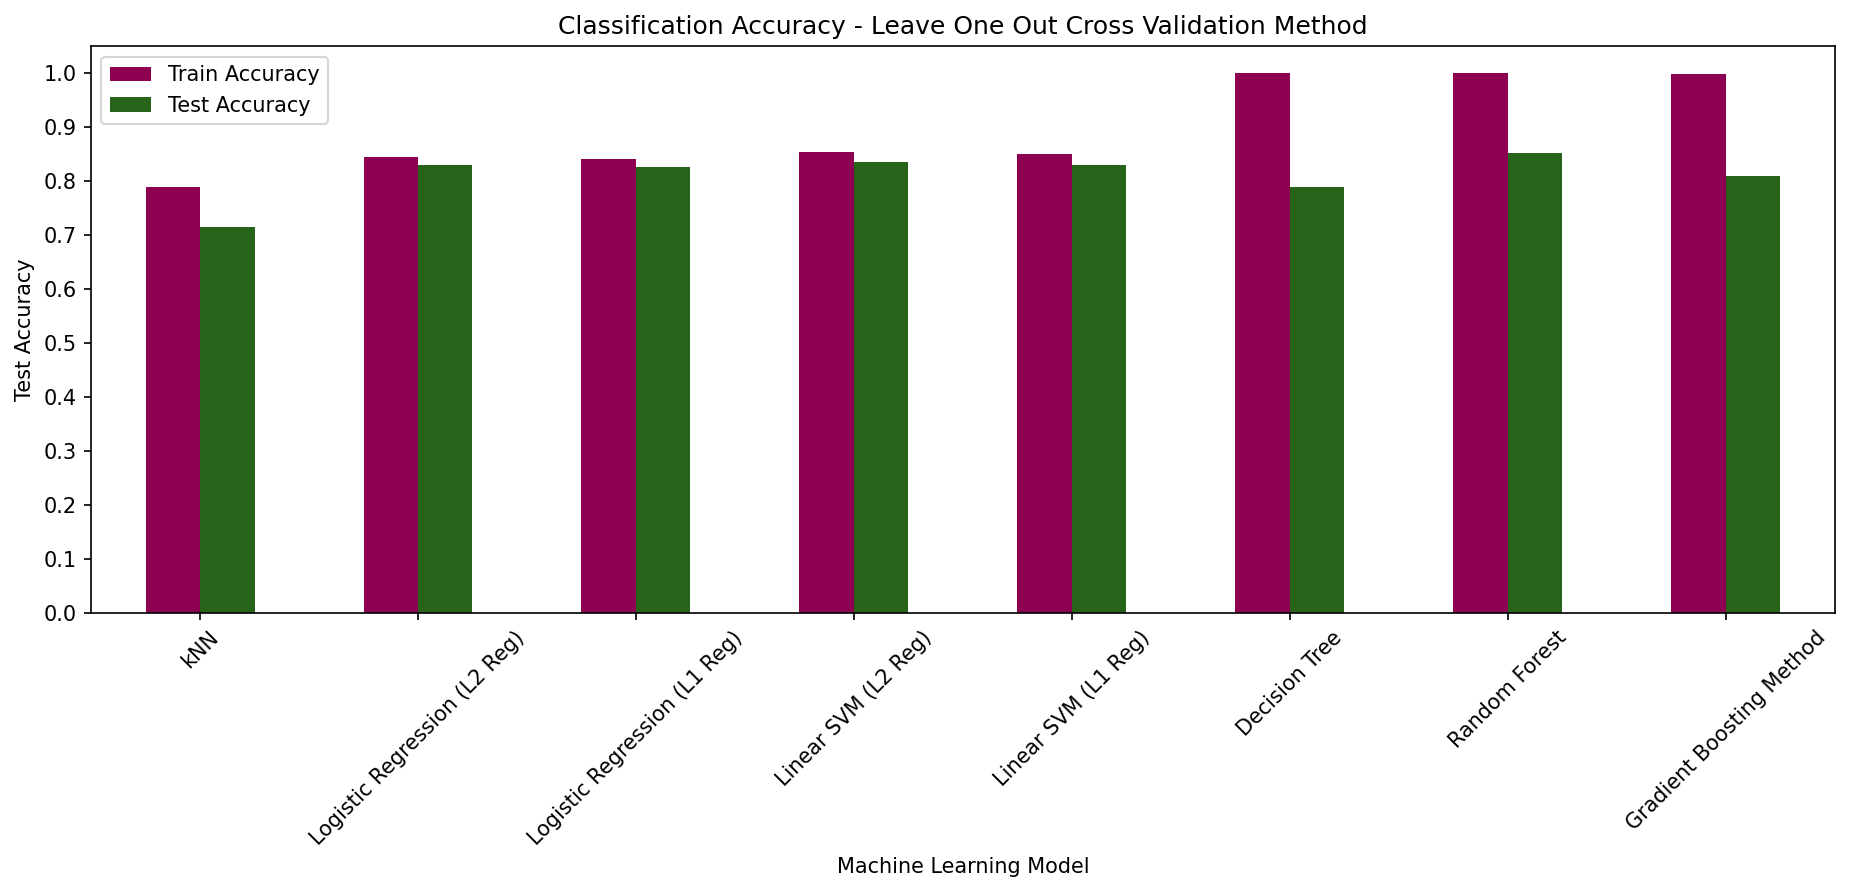

In [16]:
plt.rcParams["figure.dpi"] = 150
df3.set_index('Machine Learning Model').plot.bar(figsize=(15,5),
                                                 colormap='PiYG')
plt.title('Classification Accuracy - Leave One Out Cross Validation Method')
plt.xlabel('Machine Learning Model')
plt.ylabel('Test Accuracy')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0,1.05)
plt.xticks(rotation=45)
plt.legend(loc='upper left')
# plt.savefig('loocv_results.png', dpi=150, bbox_inches = 'tight')
plt.show()

#### Calculating Variance

In [17]:
kNN_accuracy = []
LR_l2_accuracy = []
LR_l1_accuracy = []
LSVM_l2_accuracy = []
LSVM_l1_accuracy = []
DT_accuracy = []
RF_accuracy = []
GBM_accuracy = []

accuracies = [kNN_accuracy, LR_l2_accuracy, LR_l1_accuracy, LSVM_l2_accuracy, 
              LSVM_l1_accuracy, DT_accuracy, RF_accuracy, GBM_accuracy]

predicted = [y_pred_kNN_all, y_pred_LR_l2_all, y_pred_LR_l1_all, 
             y_pred_LSVM_l2_all, y_pred_LSVM_l1_all, y_pred_DT_all, 
             y_pred_RF_all, y_pred_GBM_all]

for model in predicted:
    for i,j in zip(y_true_all, model):
        accuracies[predicted.index(model)].append(accuracy_score(i, j))

cols = ['Machine Learning Model','Test Accuracy', 'Variance']

df4 = pd.DataFrame(columns=cols)

df4.loc[0] = ['kNN', np.mean(kNN_accuracy), np.var(kNN_accuracy)]
df4.loc[1] = ['Logistic Regression (L2 Reg)', np.mean(LR_l2_accuracy), 
              np.var(LR_l2_accuracy)]
df4.loc[2] = ['Logistic Regression (L1 Reg)', np.mean(LR_l1_accuracy), 
              np.var(LR_l1_accuracy)]
df4.loc[3] = ['Linear SVM (L2 Reg)', np.mean(LSVM_l2_accuracy), 
              np.var(LSVM_l2_accuracy)]
df4.loc[4] = ['Linear SVM (L1 Reg)', np.mean(LSVM_l1_accuracy), 
              np.var(LSVM_l1_accuracy)]
df4.loc[5] = ['Decision Tree', np.mean(DT_accuracy), 
              np.var(DT_accuracy)]
df4.loc[6] = ['Random Forest', np.mean(RF_accuracy), 
              np.var(RF_accuracy)]
df4.loc[7] = ['Gradient Boosting Method', np.mean(GBM_accuracy), 
              np.var(GBM_accuracy)]

df4

,Machine Learning Model,Test Accuracy,Variance
0,kNN,0.715719,0.203465
1,Logistic Regression (L2 Reg),0.829431,0.141475
2,Logistic Regression (L1 Reg),0.826087,0.143667
3,Linear SVM (L2 Reg),0.836120,0.137023
4,Linear SVM (L1 Reg),0.829431,0.141475
5,Decision Tree,0.789298,0.166307
6,Random Forest,0.852843,0.125502
7,Gradient Boosting Method,0.809365,0.154294


#### Identifying Feature Importance for DT,  RF, and GBM Classifiers (LOOCV)

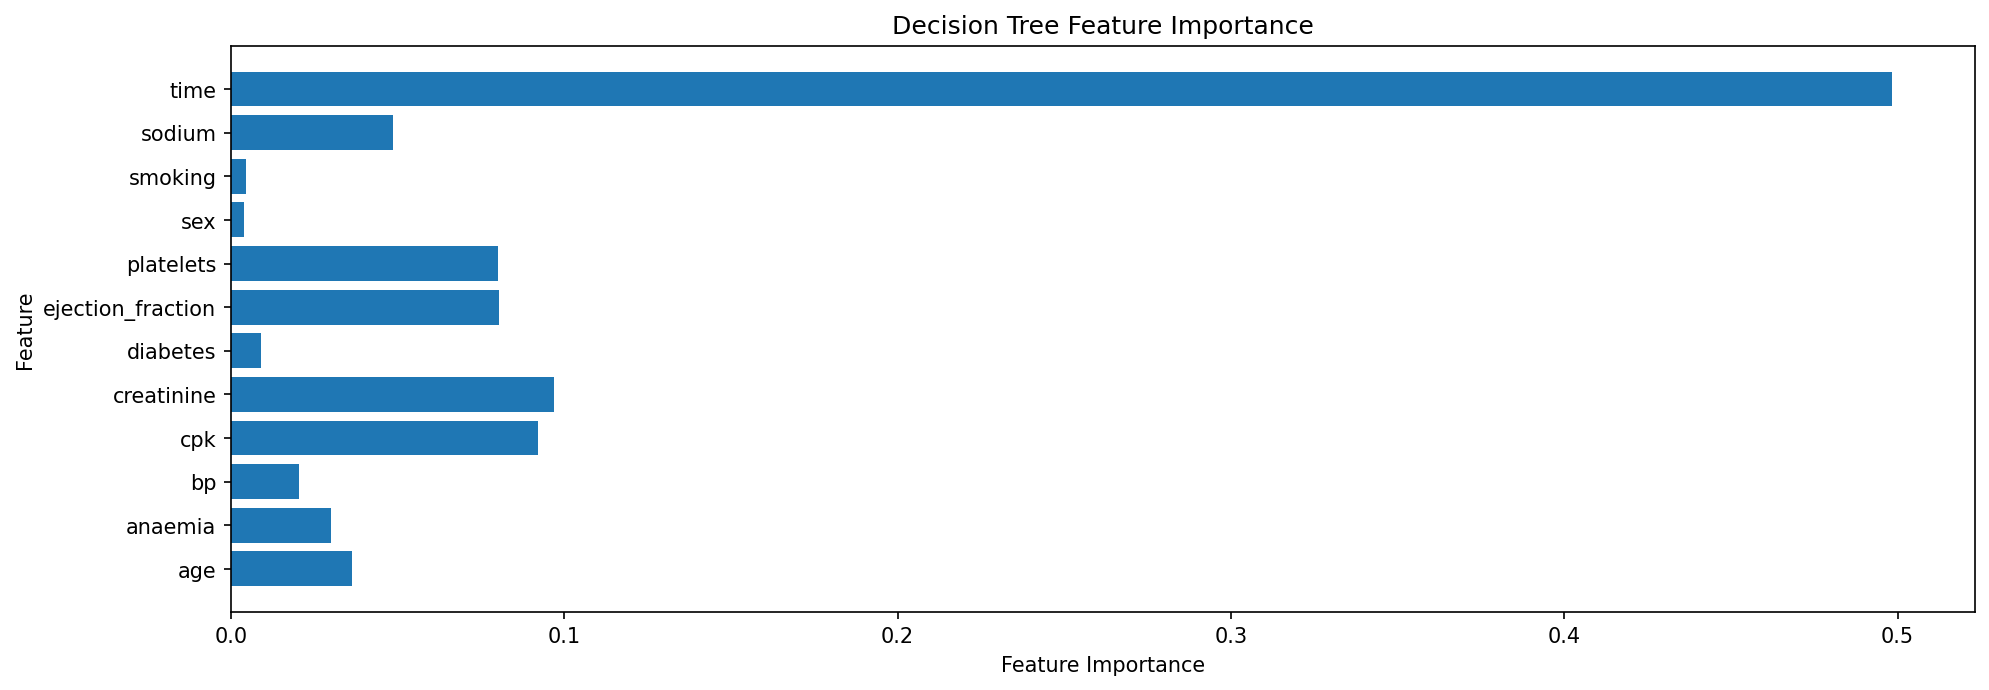

In [18]:
plt.figure(figsize=(15,5), dpi=150)
n_features = df_data.shape[1]
plt.barh(range(n_features), np.mean(DT_features,axis=0), align='center')
plt.yticks(np.arange(n_features), df_data.columns)
plt.title('Decision Tree Feature Importance')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

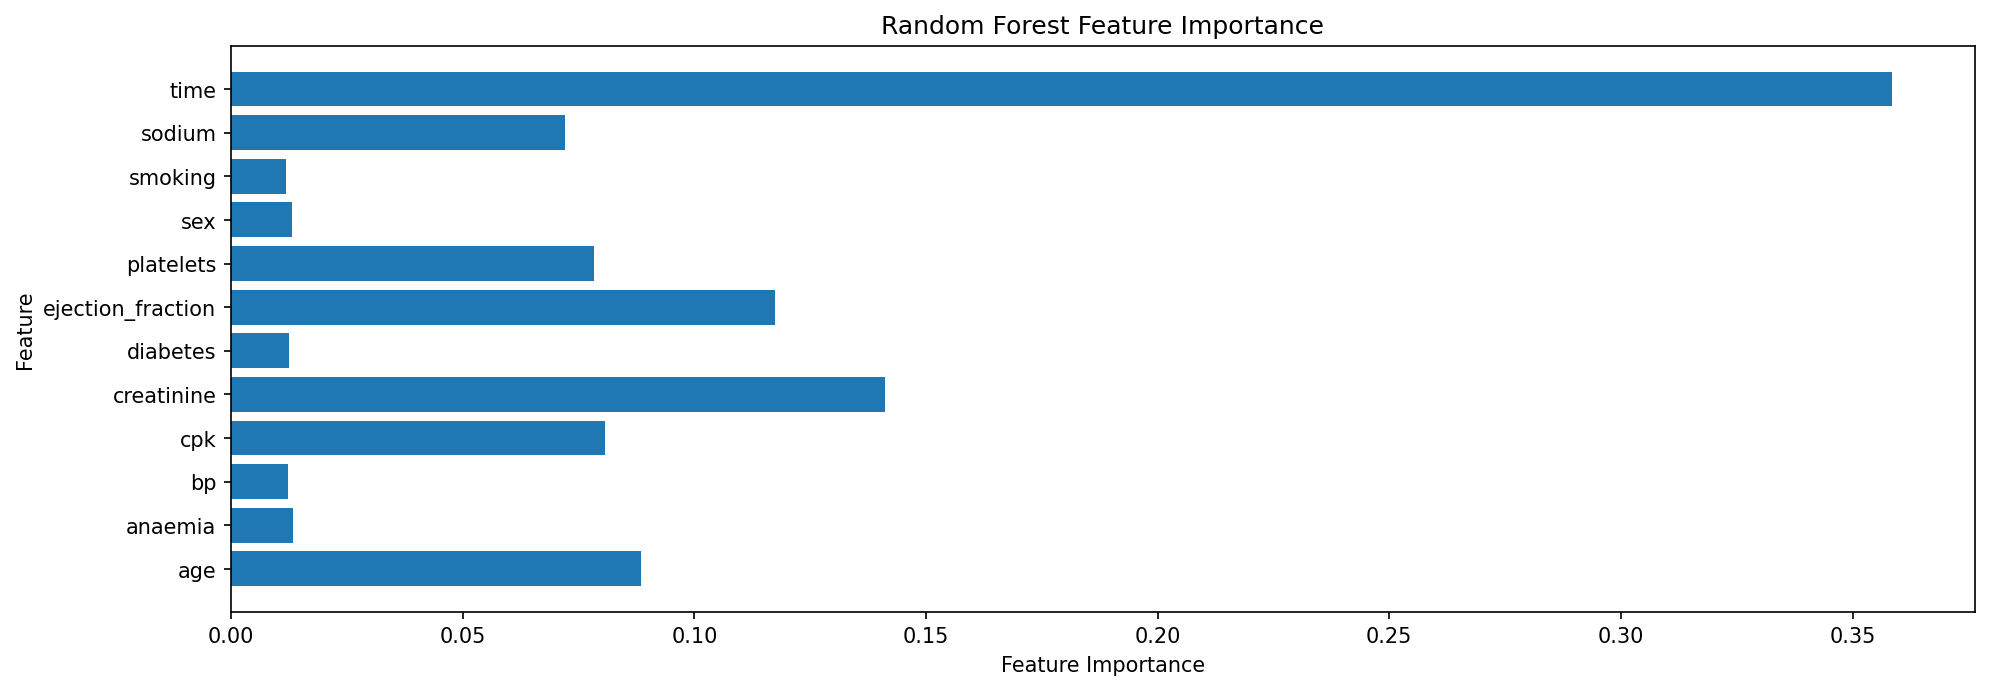

In [19]:
plt.figure(figsize=(15,5), dpi=150)
n_features = df_data.shape[1]
plt.barh(range(n_features), np.mean(RF_features,axis=0), align='center')
plt.yticks(np.arange(n_features), df_data.columns)
plt.title('Random Forest Feature Importance')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

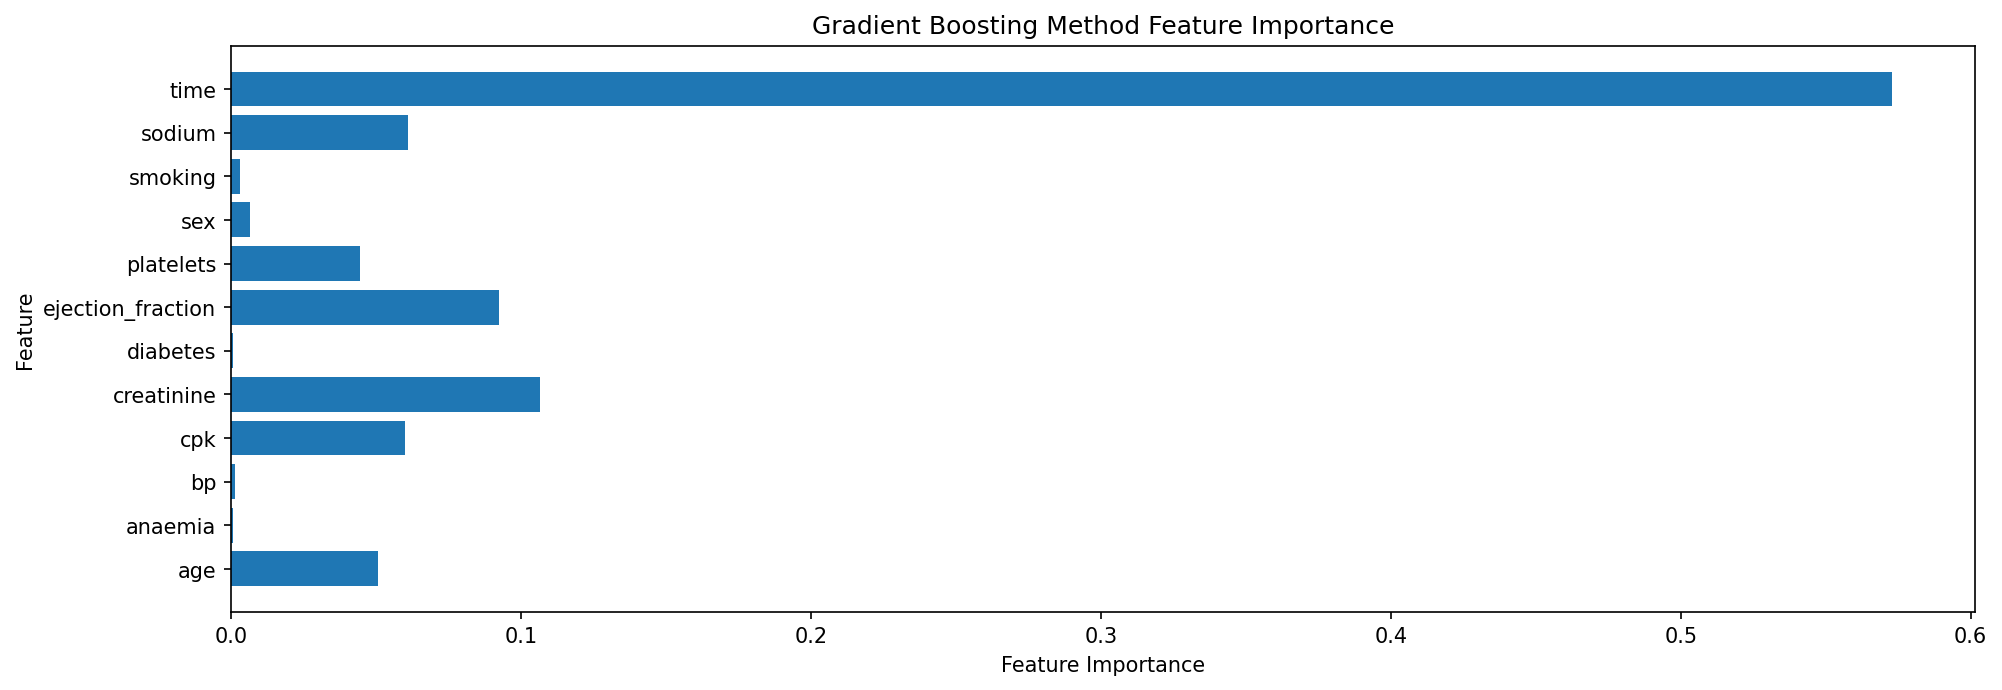

In [20]:
plt.figure(figsize=(15,5), dpi=150)
n_features = df_data.shape[1]
plt.barh(range(n_features), np.mean(GBM_features,axis=0), align='center')
plt.yticks(np.arange(n_features), df_data.columns)
plt.title('Gradient Boosting Method Feature Importance')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

We can see above the features concerning blood chemistry (`creatinine`, `platelets`, `cpk`, `sodium` etc.) are important for all three models.

## Comparison of Train-test split and LOOCV Test Accuracies

,Train-test split,Leave One Out CV
Machine Learning Model,,
kNN,0.693333,0.715719
Logistic Regression (L2 Reg),0.880000,0.829431
Logistic Regression (L1 Reg),0.853333,0.826087
Linear SVM (L2 Reg),0.840000,0.836120
Linear SVM (L1 Reg),0.840000,0.829431
Decision Tree,0.786667,0.789298
Random Forest,0.906667,0.852843
Gradient Boosting Method,0.866667,0.809365


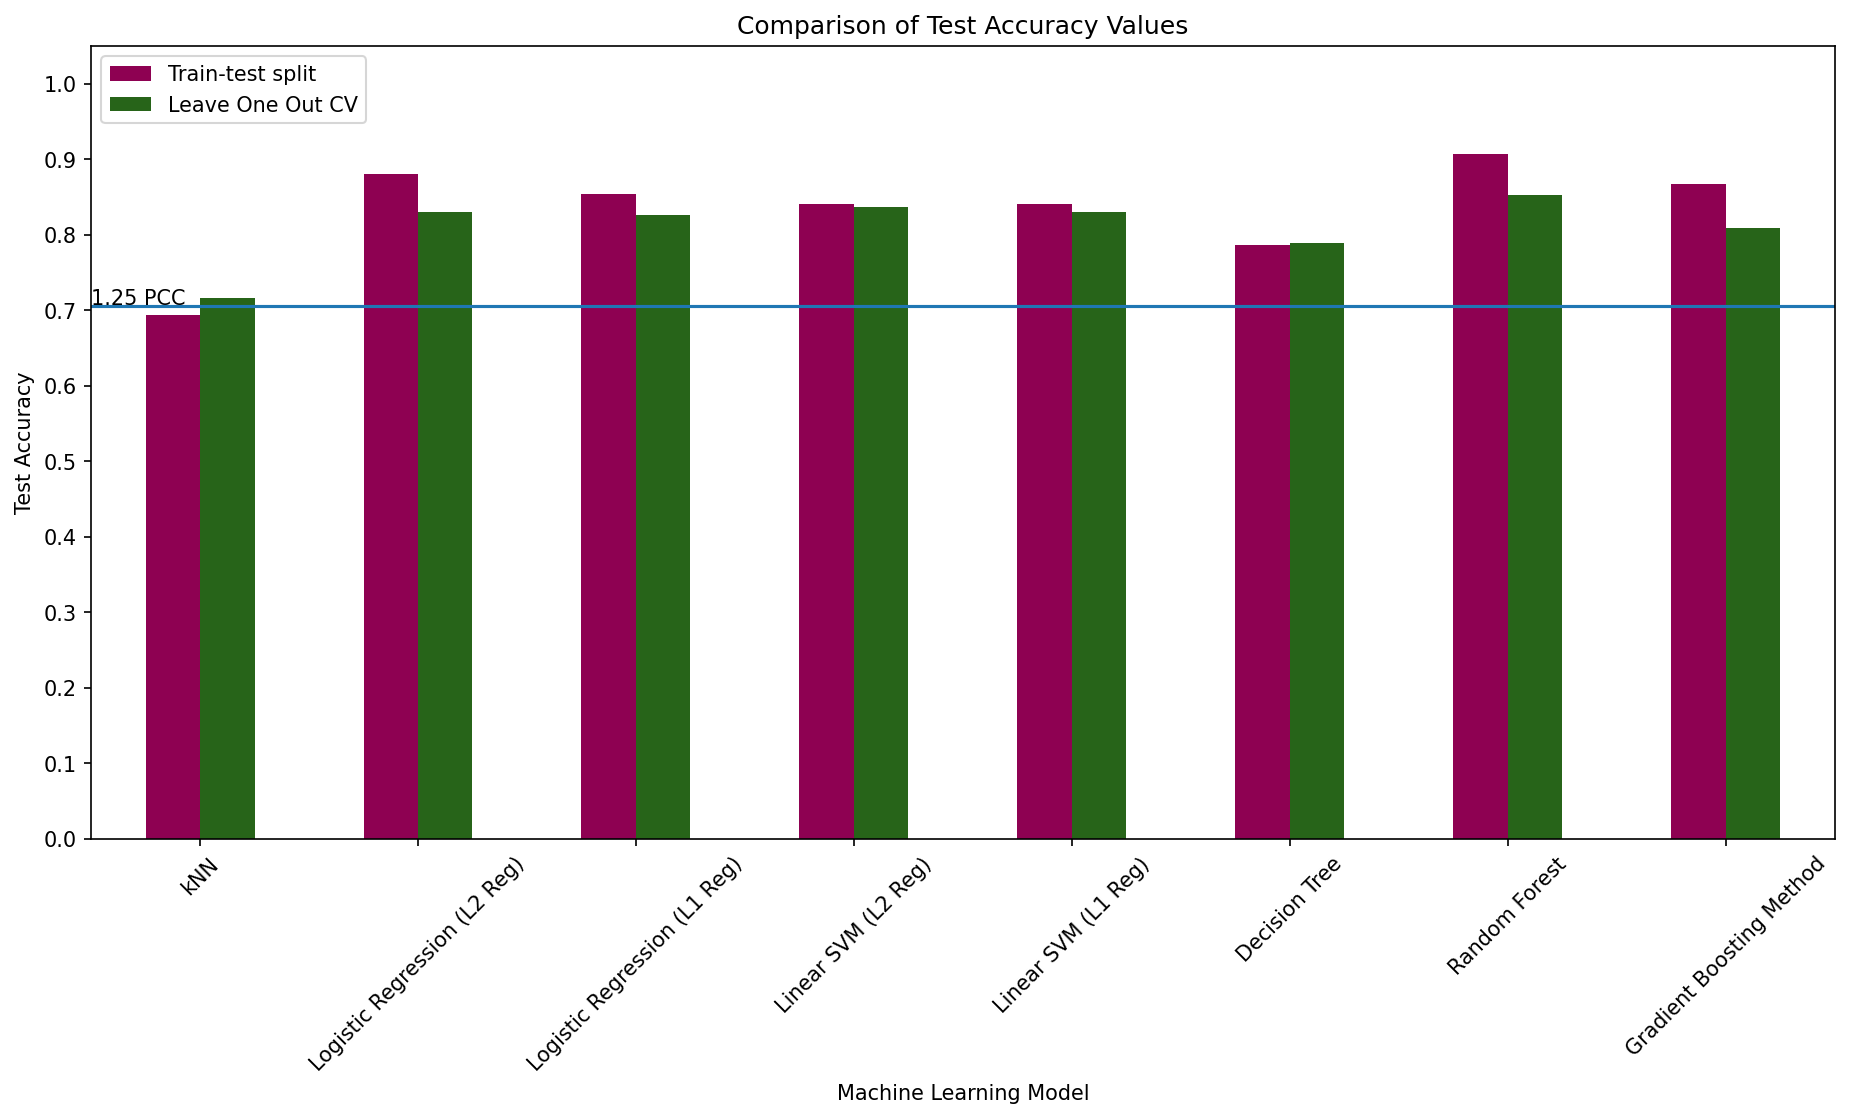

In [21]:
df2_temp = (df2[['Machine Learning Model', 'Test Accuracy']]
            .set_index('Machine Learning Model')
            .rename(columns={'Test Accuracy':'Train-test split'}))
df3_temp = (df3[['Machine Learning Model', 'Test Accuracy']]
            .set_index('Machine Learning Model')
            .rename(columns={'Test Accuracy':'Leave One Out CV'}))

df_results = df2_temp.join(df3_temp)

display(df_results)

plt.rcParams["figure.dpi"] = 150
df_results.plot.bar(figsize=(15,7), colormap='PiYG')
plt.title('Comparison of Test Accuracy Values')
plt.xlabel('Machine Learning Model')
plt.ylabel('Test Accuracy')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0,1.05)
plt.xticks(rotation=45)
plt.axhline(0.705)
plt.annotate('1.25 PCC', (-0.5,0.7075))
plt.legend(loc='upper left')
# plt.savefig('results_summary.png', dpi=150, bbox_inches = 'tight')
plt.show()

## Discussion on usage of LOOCV over usual train-test split

The Leave One Out Cross Validation (LOOCV) method is an extreme version of k-fold cross validation, wherein all but one of the dataset is used as the learning set and the test set is the one left out (Pedregosa et al., 2011). So for this study, in the implementation of the LOOCV method, 299 models for each algorithm were developed and 299 accuracy values were calculated. To get the final accuracy value per algorithm, the 299 calculated accuracies were averaged.

The advantage of using LOOCV over the usual train-test split is the more robust estimation of the model's performance. Since we're using the whole dataset, bias is minimized and overestimation of error is reduced. Randomness due to data splitting is also removed in the results. In fact, LOOCV is usually preferred over the usual train-test split when the dataset is small (typically less than 1 thousand samples), or when robustness of accuracy is preferred over computational costs. Disadvantage of LOOCV though, is that the calculated accuracies can be highly variable and the procedure is computationally expensive. This method is generally not advised to be used in large datasets (Pedregosa et al., 2011; Brownlee, 2020; Patel, 2016). In terms of total runtime of the two methods in the study, the train-test split method only took around 2 seconds to complete the 8 ML algorithms, while the LOOCV method took around 4 mins to complete the run for the 8 ML algorithms.

So to answer the question, "what can we do for publicly available datasets but with small sample sizes?", we can use the LOOCV method to produce more robust results compared to the usual train-test split method. However, do note that while LOOCV can improve results from the usual train-test method, i.e. increase accuracy, it cannot magically make a low to medium test accuracy be good or better, e.g. increase a 60-70% accuracy to 90% (train-test and LOOCV accuracies, respectively).

## Applying ML in a Biological Context

Looking at the comparison of the calculated test accuracies of the dataset in the figure above, we can see that only kNN and the DT algorithm has higher LOOCV test accuracies compared to the train-test split method. The other test accuracies are lower, but still within a comparable range. The results of the comparison are as expected, with test accuracies calculated via LOOCV to be lower but still within a comparable range.

In terms of model selection for predicting heart failure, we want the accuracy values to be robust. Following this line of argument, it is preferable to pick the models produced via LOOCV compared to the train-test split. The calculated test accuracies via the LOOCV method is also higher than the 1.25 PCC (0.705), which means that all of them can predict better than chance.

Moving forward, let's say we picked the RandomForest classifier with default settings as our model of choice based on the calculated test accuracy of 85%. How do we proceed from here on? Well, we can optimize the model further since there is overfitting. By optimizing, we can increase the accuracy, determine how feature ranking changes, and then interpret the results. But these are standard steps for any application of machine learning, and in the interest of saving time and highlighting my learning point, I'll skip the optimization. My next point would not change whether we optimize the model or not.

What I want to highlight is the model application and its interpretation in a biological context. Even though we have a high accuracy of 85%, and we increase this to say 95%, we still need to be skeptical of the predictions when we use this model to predict  for non-Pakistani people. The study and the data was done in a Pakistani context. Applying this model to non-Pakistani people includes some context changes on a molecular level (interactions between proteins involving blood etc.), that even traditional machine learning models might not account for. In my opinion, the value that this methodology and model can give when applied in a different context is that it can provide us with a base expectation of what can happen. However, it's still the responsibility of the researchers, or doctors, to continuously monitor the situation and use their judgement and domain knowledge for decision making. The ML model is used to augment decision making, not replace the decision maker. 

## Reference

Ahmad, T., Munir, A., Bhatti, S., Aftab, M., & Raza, M. (2017). Survival analysis of heart failure patients: A case study. *PLoS ONE, 12(7)*. doi:https://doi.org/10.1371/journal.pone.0181001

Brownlee, J. (2020). *LOOCV for Evaluating Machine Learning Algorithms*. Retrieved from Machine Learning Mastery: https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/

Patel, M. (2016). *LOOCV*. Retrieved from RPubs: https://rpubs.com/maulikpatel/226237

Pedregosa. (2011). Scikit-learn: Machine Learning in Python. *JMLR*. Retrieved from: https://scikit-learn.org/stable/about.html